<a href="https://colab.research.google.com/github/Mark-Barbaric/IBM_Machine_Learning_Certificate/blob/dl_week4/Deep_Learning_and_Reinforcement_Learning/week4/bulding_a_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Building a CNN**


## A mission to automate monitoring of flowering

Climate warning is causing a lot of changes in the timing and duration of flowering seasons, making it hard for the flower planting company to monitor the growing of various species. To study the changes, the company's biologists are monitoring the plants in small permanently marked areas and performing manual collection and analysis of the plant phenology details.

You are now hired by the company as a Data Scientist to help automate the monitoring process. The first step of your mission is to create a flower type identification system, so that it could greatly reduce the time and cost of tracking the flowers on an indivifual level.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/flowershop.jpeg" width="80%"></center>


In this lab, we will tie together everything we've learned in previous CNN labs and apply our new found skills in a object recognition task.

This lab takes concepts learned in this Deep Learning and Reinforcement Learning course and applies them in the creation of a CNN model.

We will be implementing a model that classifies images employing multiple convolutional **filters** for multi-**channel**/RGB images, adding **padding** to images to preserve image sizes/capture edge data, determining the best **stride** to use with the convolutional filters, passing that data through **activation functions** such as ReLU and **pooling** layers, and **flattenning** our results to obtain classes using **categorical cross entropy**.


## Table of Contents

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
        </ol>     
    </li>
    <li>
        <a href="#Example: Classifying Flowers">Example: Classifying Flowers</a>
        <ol>
            <li><a href="#Importing data">Importing data</a></li>
            <li><a href="#Building a classifier">Building a classifier</a></li>
            <li><a href="#Prediction!">Prediction!</a></li>
        </ol>   
    </li>
</ol>


## Objectives

After completing this lab you will be able to:

*   Explain how a convolution works on images
*   Understand the purposes of different kernels that exist
*   Apply kernels to images and obtain a useful result


In [23]:
!pip install opencv-python==4.5.5.62 skillsnetwork

In [24]:
import warnings
warnings.simplefilter('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image, ImageOps
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Defining Helper Functions


This function helps visualize the feature maps of the layers in a classifier.


In [25]:
def plot_activations_multilayer(num_layers, images_per_row, classifier, activations):
    layer_names = []
    for layer in classifier.layers[:num_layers]:
        layer_names.append(layer.name + ' layer')  # Names of the layers, so you can have them as part of your plot
    for layer_name, layer_activation in zip(layer_names, activations):  # Displays the feature maps
        n_features = layer_activation.shape[-1]  # Number of features in the feature map
        size = layer_activation.shape[1]  # The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :,
                                                 col * images_per_row + row]
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 2. / size
        plt.figure(figsize=(scale*display_grid.shape[1],
                            scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Example: Classifying Flowers


We will use our flower images from the image convolution lab. However, this time, we want to use them to train a CNN model for classification. Hence, we will utilize a training and test set.
https://www.tensorflow.org/tutorials/load_data/images


### Importing data

Lets take a look at the flowers dataset from tensorflow, retrieved from here: [https://www.tensorflow.org/datasets/catalog/tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)


In [26]:
import skillsnetwork

dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/datasets/flower_photos.tgz"
await skillsnetwork.prepare(dataset_url, overwrite=True)

  0%|          | 0/3677 [00:00<?, ?it/s]

Saved to '.'


In [27]:
data_dir = Path("flower_photos")

for folder in data_dir.glob('[!LICENSE]*'):
    print('The', folder.name, 'folder has',
          len(list(folder.glob('*.jpg'))), 'pictures')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count, 'total images')

The dandelion folder has 898 pictures
The roses folder has 641 pictures
The daisy folder has 633 pictures
The tulips folder has 799 pictures
The sunflowers folder has 699 pictures
3670 total images


In [28]:
img_width = 150
img_height = 150

batch_size = 64
epochs = 10

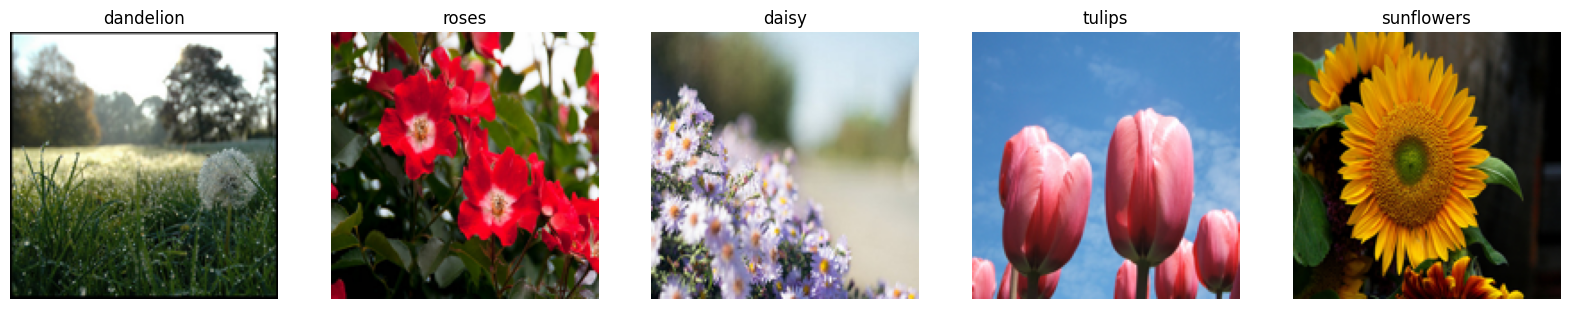

In [29]:
pics = []
pics_arr = []
p_class = []

plt.figure(figsize=(20, 5))

for idx, folder in enumerate(data_dir.glob('[!LICENSE]*')):
    cat = list(data_dir.glob(folder.name + '/*'))
    pic = PIL.Image.open(str(cat[0])).resize((img_width, img_height))
    pic_arr = np.array(pic)
    clss = folder.name

    plt.subplot(1,5,idx+1)
    plt.imshow(pic)
    plt.title(clss)
    plt.axis('off')

    pics.append(pic)
    pics_arr.append(pic_arr)
    p_class.append(clss)

Let's create a train set using the `ImageDataGenerator` and `flow_from_directory` functions from `keras.utils`.


In [30]:
train_gen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_set = train_gen.flow_from_directory(
    directory=data_dir,
    seed=10,
    class_mode="sparse",
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_height, img_width),
    subset='training'
)

Found 2939 images belonging to 5 classes.


In [31]:
validation_gen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1.0 / 255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

validation_set = validation_gen.flow_from_directory(
    directory=data_dir,
    seed=10,
    class_mode="sparse",
    batch_size=batch_size,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="validation"
)

Found 731 images belonging to 5 classes.


In [32]:
class_names = {
    y: x for x, y in validation_set.class_indices.items()
}

In [33]:
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

### Building a classifier


In [34]:
input_shape = (img_width, img_height, 3)

In [35]:
classifier = Sequential()

In [36]:
classifier.add(
    Conv2D(
        32,
        (5, 5),
        input_shape=input_shape,
        padding="same",
        activation="relu"
    )
)
classifier.add(
    MaxPooling2D(
        pool_size=(2, 2)
    )
)
classifier.add(
    Conv2D(
        64,
        (3, 3),
        padding="same",
        activation="relu"
    )
)
classifier.add(
    MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2)
    )
)

In [37]:
classifier.add(
    Conv2D(
        32,
         (3, 3),
        padding="same",
        activation="relu")
)
classifier.add(
    MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2)
    )
)
classifier.add(
    Conv2D(
        32,
        (3, 3),
        padding="same",
        activation="relu"
    )
)
classifier.add(
    MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2)
    )
)

In [38]:
classifier.build((None, img_width, img_height, 3))
classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 37, 37, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 32)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,640 (190.00 KB)

 Trainable params: 48,640 (190.00 KB)

 Non-trainable params: 0 (0.00 B)

Let's try to see how the layers look so far when applied on a sample image without training (call the `predict` method directly on the **img_tensor**.


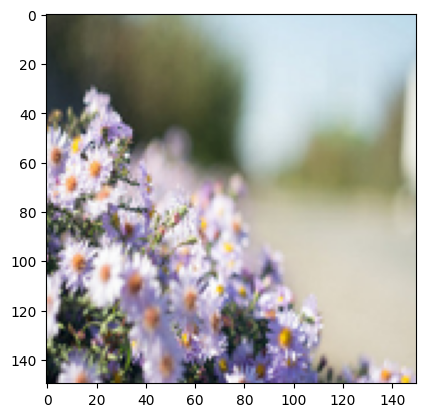

In [39]:
img_tensor = np.array(pics_arr[2], dtype='int')
plt.imshow(img_tensor)

Before we input the image to the CNN, we have to add the batch dimension using ```np.expand_dims```


In [40]:
img_tensor = np.expand_dims(img_tensor, axis=0)
y = classifier.predict(img_tensor)

print(f"The predicted output of the sample image has a shape of {y.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
The predicted output of the sample image has a shape of (1, 9, 9, 32)


From the summary above we saw there are 7 layers in **classifier**. We can use the helper function **plot_activations_multilayer** to visualize the feature maps produced by each layer before training.


In [41]:
classifier.predict(np.zeros((1, img_width, img_height, 3)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [42]:
classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 37, 37, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 32)            │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,640 (190.00 KB)

 Trainable params: 48,640 (190.00 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
classifier.layers[0].input

<KerasTensor shape=(None, 150, 150, 3), dtype=float32, sparse=None, name=keras_tensor_45>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


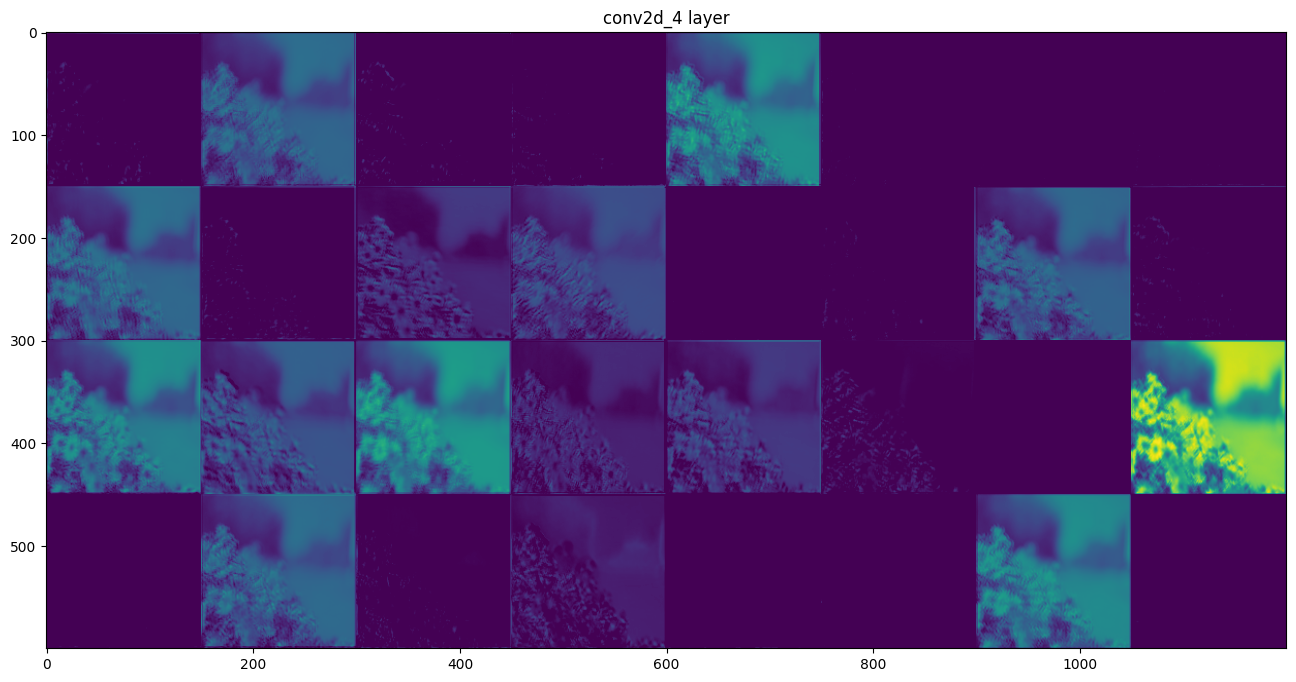

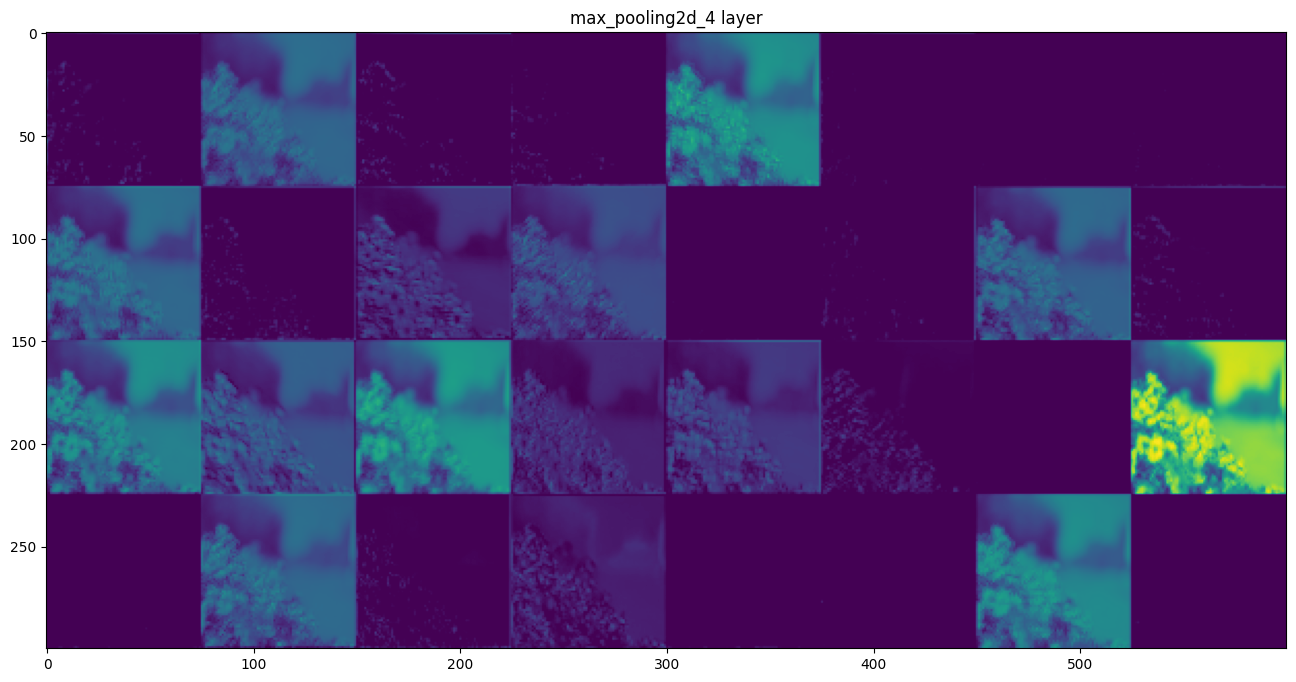

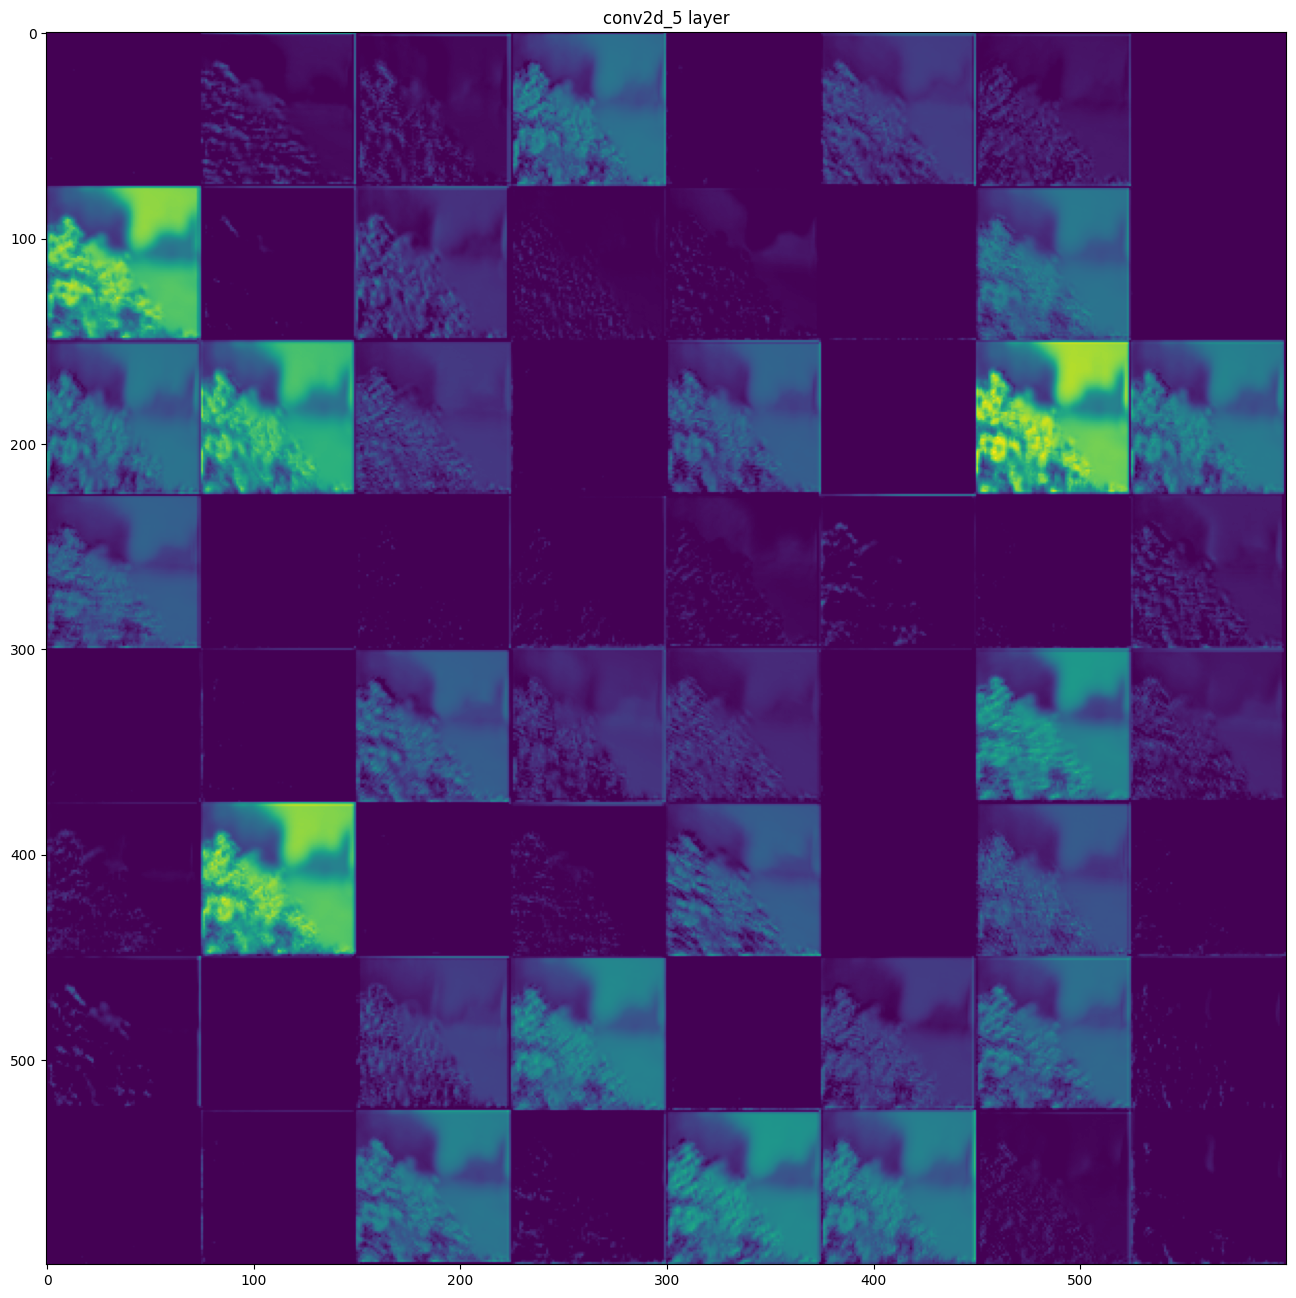

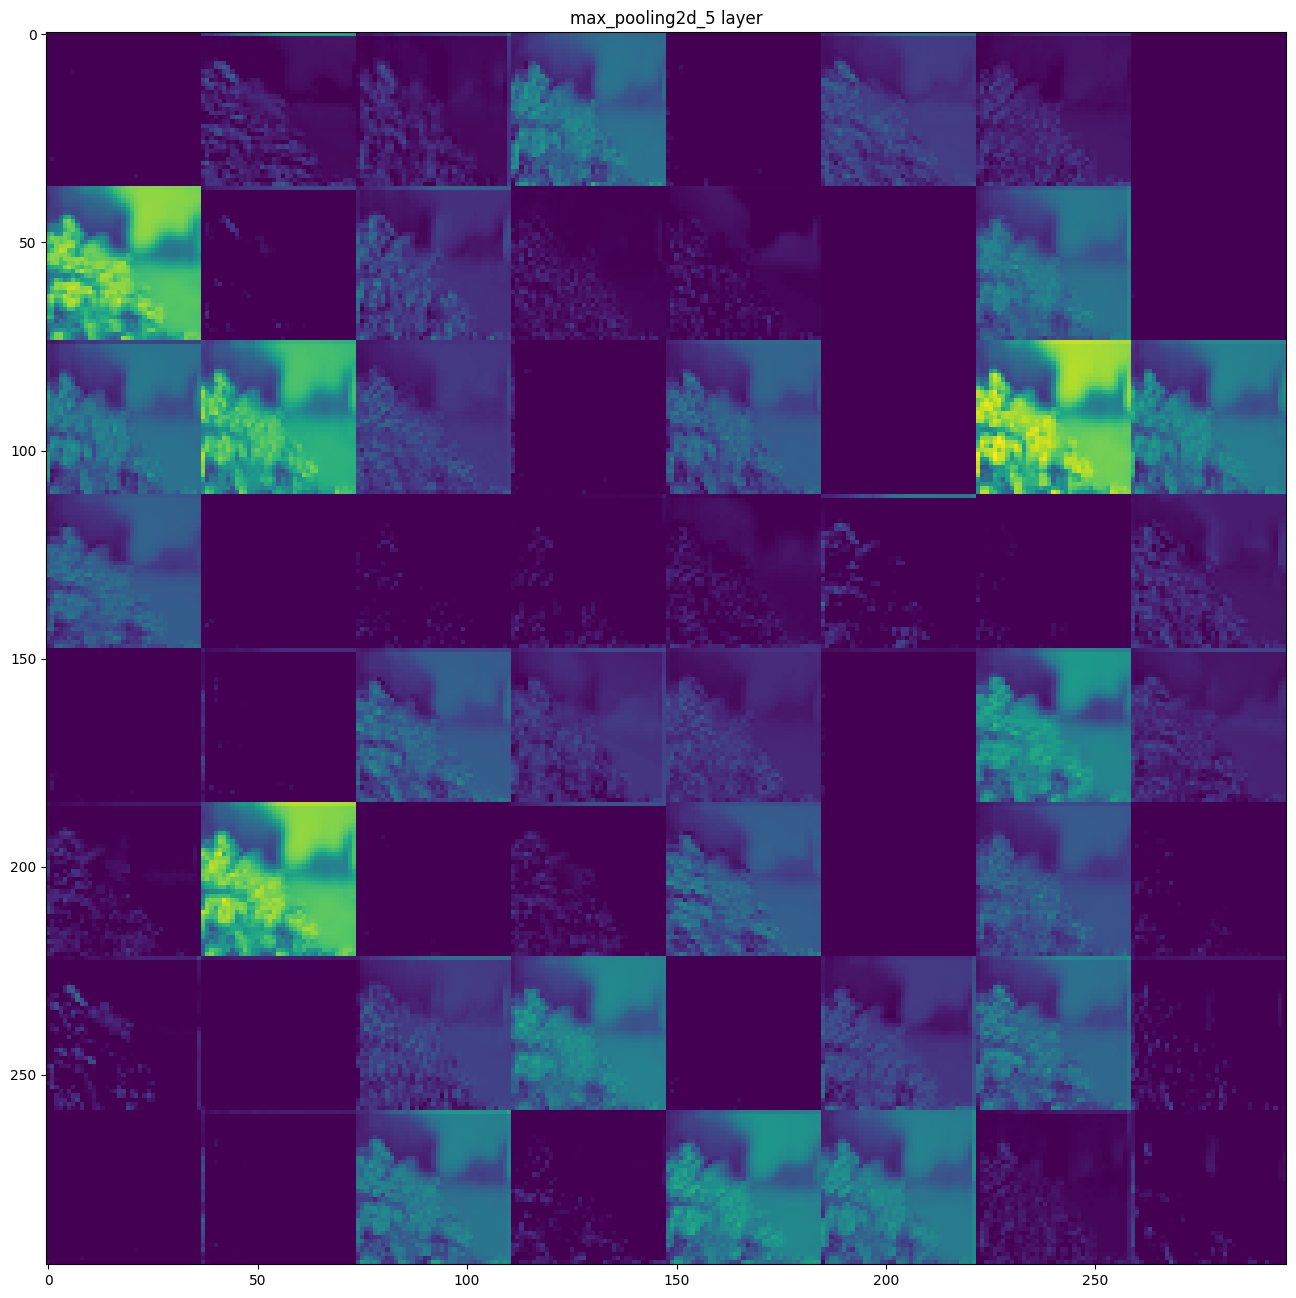

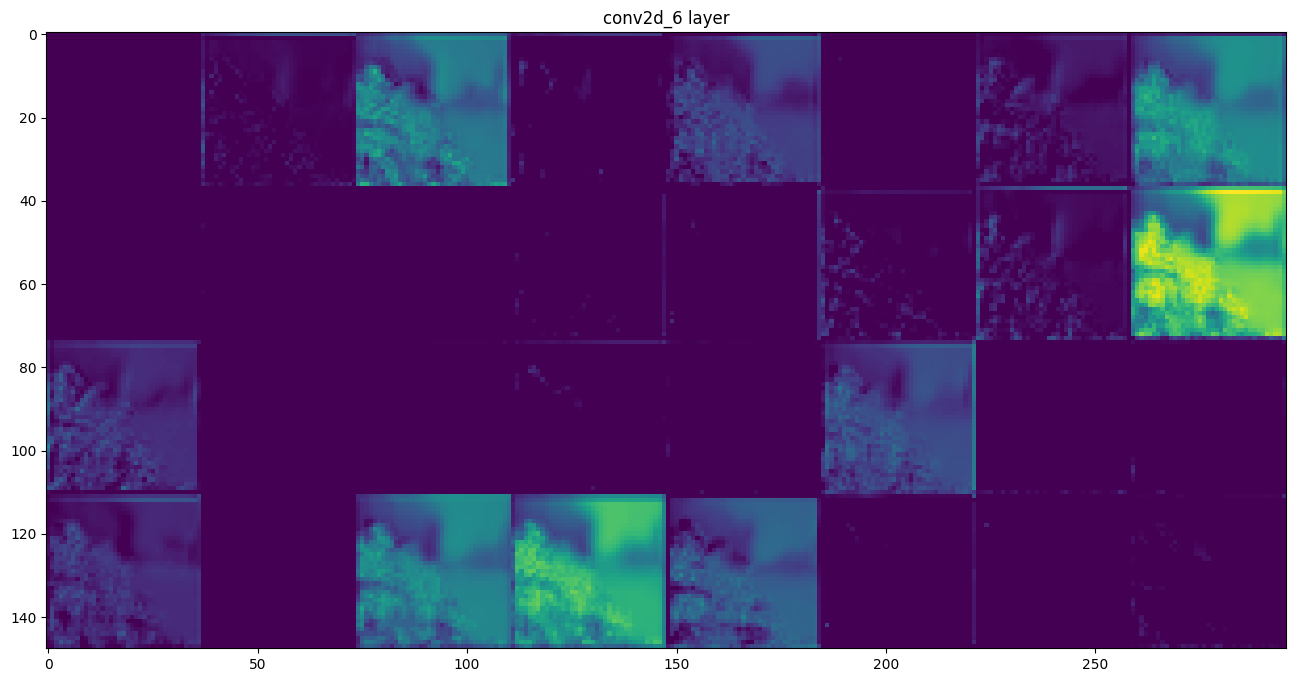

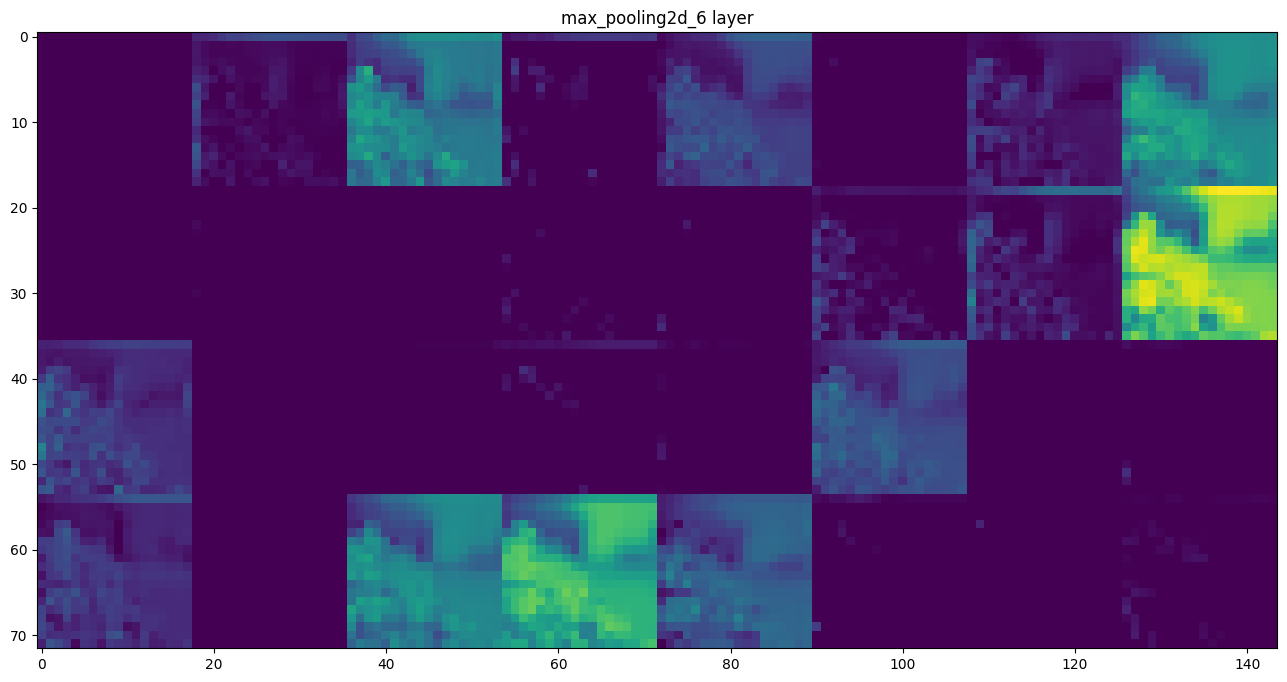

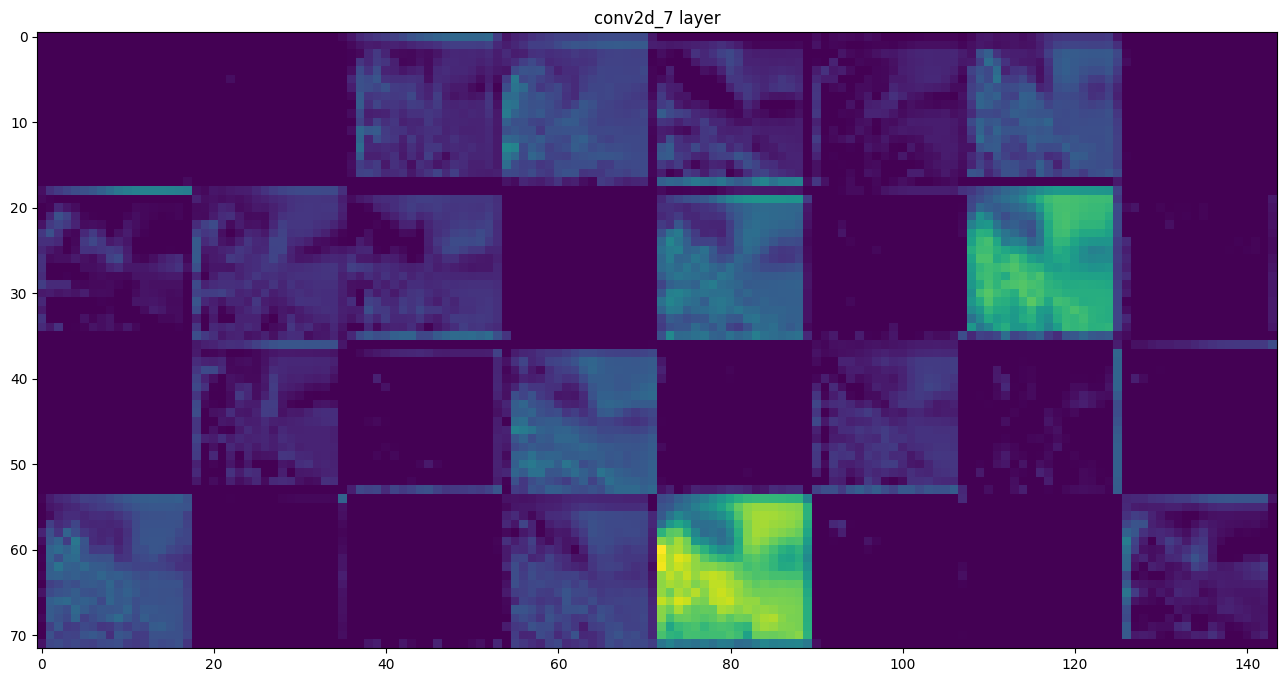

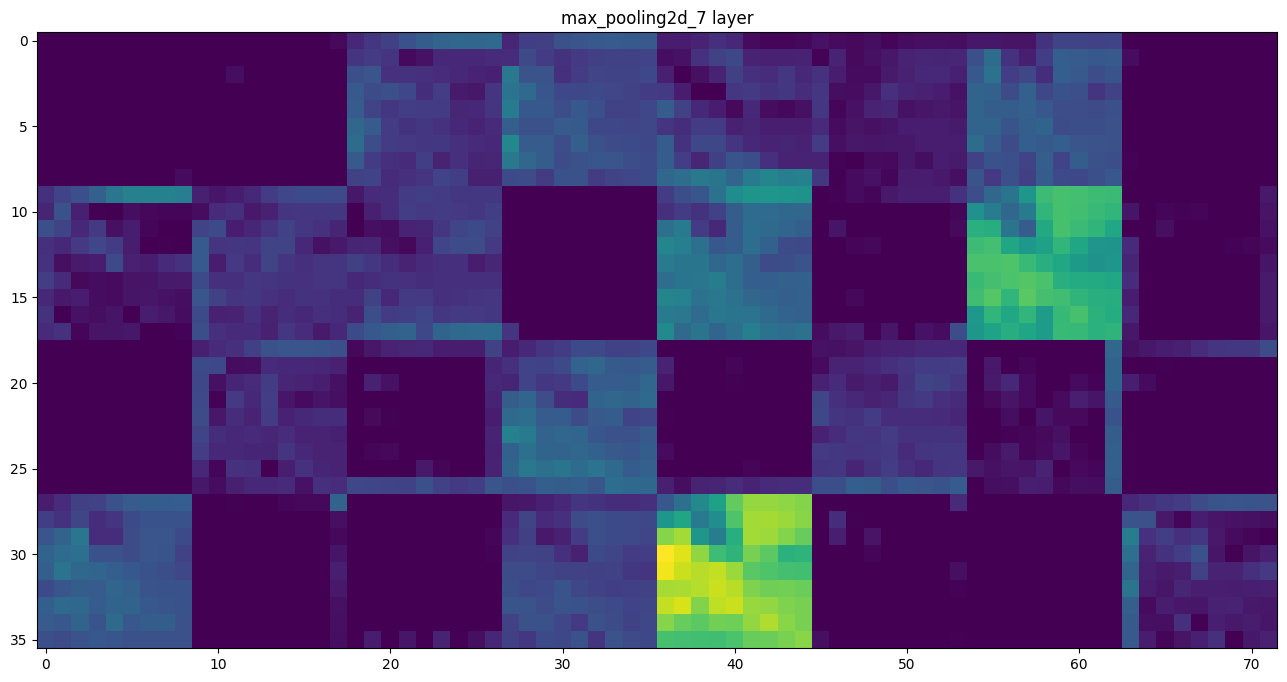

In [45]:
layer_outputs = [layer.output for layer in classifier.layers]
activation_model = Model(
    inputs=classifier.layers[0].input,
    outputs=layer_outputs
)
activations = activation_model.predict(img_tensor)
plot_activations_multilayer(8, 8, classifier, activations)

Although the **classifier** model hasn't been trained, it is already evident that certain features are getting recognized in each separate layer. Now, let's proceed with building the model for classification.


#### Exercise: Add a Flattening layer


From the summary above, we see that the shape of the output of the previous layer is $73\times73\times6$. Thus, the shape of the output of our flattening layer will be  $73\times73\times6 = 31974\times1$.


In [46]:
classifier.add(
    Flatten()
)

#### Exercise: Add Dense Layers


Now the last step of building the **classifier** model is adding some fully-connected dense layers:

- Dense layer with 512 units and relu activation function.
- Dense layer with 5 units (because the dataset has 5 classes) and softmax activation function.


In [47]:
classifier.add(
    Dense(
        units=512,
        activation="relu"
    )
)

In [49]:
classifier.add(
    Dense(
        units=5,
        activation="softmax"
    )
)

In [50]:
classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 150, 150, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 37, 37, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 18, 18, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 9, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2592)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,327,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,821 (5.26 MB)

 Trainable params: 1,378,821 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

### Prediction!

We compile the model using the Adam optimizer, categorical cross entropy as the loss function, and measuring performance based on its accuracy.


In [53]:
classifier.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

Let's fit the classifier on the train set and evaluate its performance against the validation set

**Note: This may take some time, go make yourself a coffee while waiting!**


In [ ]:
classifier.fit(
    train_set,
    validation_data=validation_set,
    epochs=epochs
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 175s 4s/step - accuracy: 0.2785 - loss: 1.5398 - val_accuracy: 0.5048 - val_loss: 1.2292
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.5253 - loss: 1.1387 - val_accuracy: 0.5226 - val_loss: 1.1294
Epoch 3/10
23/46 ━━━━━━━━━━━━━━━━━━━━ 1:23 4s/step - accuracy: 0.5807 - loss: 1.0564

Now that the network is trained and the kernels (the weight matrices of the layers) are learnt, we can visualize the kernels. For each Conv2d layer in the list of `classifier.layers`, it consists of multiple kernels (filters). To match the depth of the input to a Conv2d layer, each kernel's depth will have the same value as the input depth. The kernel depth is also referred to as the number of channels of a kernel.

For example, if the input to the first Conv2d layer is a 3-channel RGB image, then each kernel of the layer will consist of three channels (depth 3) where each channel can be visualized as a 2D grayscale image. Depending on how many different feature maps we want a Conv2d layer to learn, we specify the number of kernels (filters) in a layer.

With this idea in mind, let's look at how many kernels are learnt by our classifier:


In [ ]:
for layer in classifier.layers:
  if 'conv2d' in layer.name:
    kernels, biases = layer.get_weights()
    print(f"layer_name: {layer.name}, num kernels: {kernels.shape[-1]}, kernel shape: {kernels.shape[:2]}, kernel depth: {kernels.shape[2]}")

You can see that except for the first Conv2d layer, others all have depth of 32 or 64, which means to visualize each kernel we would need to plot out 32 or 64 channels of it! To not bombard you with hundreads and thousands of kernel images, we will just visualize 3 channels of 4 kernels from each Conv2d layer:


In [ ]:
for layer in classifier.layers:
  if "conv2d" in layer.name:
    name = layer.name

    kernels, _ = layer.get_weights()
    k_min, k_max = kernels.min(), kernels.max()
    kernels = (kernels - k_min) / (k_max - k_min)

    for i in range(4):
        kernel = kernels[:,:,:,i]
        fig = plt.figure(figsize=(5, 2))
        fig.suptitle(f"{name}, kernel {i+1}", fontsize=15)

        for j in range(3):
            plt.subplot(1, 3, j+1)
            plt.imshow(kernel[:,:,j], cmap='gray')
            plt.xticks([])
            plt.yticks([])

The dark squares indicate small or inhibitory weights of the kernel and the light squares represent large or excitatory weights of the kernel. Using this intuition, we can see that, a kernel (filter) like the following detects a gradient from light in the top left to dark in the bottom right.


In [ ]:
plt.imshow(kernels[:, :, 2, 3], cmap="grey")

After seeing the kernels used for convolution, let's take a look again at what the feature maps produced by the trained, intermediate layers look like:


In [ ]:
layer_outputs = [layer.output for layer in classifier.layers]
activation_model = Model(inputs=classifier.layers[0].input, outputs=layer_outputs)

In [ ]:
# let's pick a sample image
img_tensor = pics_arr[1]
plt.imshow(np.array(img_tensor, dtype='int'))

In [ ]:
img_tensor = np.expand_dims(img_tensor, axis=0)

activations = activation_model.predict(img_tensor)[:6]

plot_activations_multilayer(7,8,classifier,activations)

In [ ]:
y = classifier.predict(img_tensor)
label = class_names[np.argmax(y)]

plt.imshow(img_tensor.reshape((img_width,img_height,3)).astype("uint8"))
plt.title(f"Predicted class is: {label}", fontsize=13)